In [25]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
#from datetime import datetime

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional
seed=43

In [26]:
df = pd.read_csv("/content/FinaData_2010.csv")
df

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,count
0,2010-11-19,11180.769531,11206.169922,11119.240234,11203.549805,11203.549805,219400000.0,-1.0,-1.0,1.0
1,2010-11-22,11201.660156,11206.049805,11054.530273,11178.580078,11178.580078,152850000.0,-1.0,-3.0,3.0
2,2010-11-23,11177.599609,11180.169922,10992.169922,11036.370117,11036.370117,192820000.0,-1.0,-1.0,1.0
3,2010-11-24,11037.349609,11195.990234,11037.349609,11187.280273,11187.280273,138280000.0,0.0,0.0,0.0
4,2010-11-26,11183.500000,11183.500000,11067.169922,11091.870117,11091.870117,68400000.0,-1.0,-2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
3212,2023-08-28,34441.640625,34652.910156,34441.640625,34559.980469,34559.980469,224640000.0,-1.0,-1.0,1.0
3213,2023-08-29,34531.121094,34864.421875,34531.121094,34852.671875,34852.671875,262550000.0,0.5,1.0,2.0
3214,2023-08-30,34847.800781,35025.570312,34811.738281,34890.238281,34890.238281,236070000.0,0.0,0.0,0.0
3215,2023-08-31,34909.089844,35070.210938,34719.769531,34721.910156,34721.910156,341900000.0,0.0,0.0,0.0


In [27]:
train_dates = pd.to_datetime(df['date'])
# print(train_dates.tail(15)) #Check last few dates.

#Variables for training
cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'P_mean',
        ]
#Date and volume columns are not used in training.
print(cols)

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
df_for_training.index=df['date']
df_for_training

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean']


,Open,High,Low,Close,Volume,Adj Close,P_mean
date,,,,,,,
2010-11-19,11180.769531,11206.169922,11119.240234,11203.549805,219400000.0,11203.549805,-1.0
2010-11-22,11201.660156,11206.049805,11054.530273,11178.580078,152850000.0,11178.580078,-1.0
2010-11-23,11177.599609,11180.169922,10992.169922,11036.370117,192820000.0,11036.370117,-1.0
2010-11-24,11037.349609,11195.990234,11037.349609,11187.280273,138280000.0,11187.280273,0.0
2010-11-26,11183.500000,11183.500000,11067.169922,11091.870117,68400000.0,11091.870117,-1.0
...,...,...,...,...,...,...,...
2023-08-28,34441.640625,34652.910156,34441.640625,34559.980469,224640000.0,34559.980469,-1.0
2023-08-29,34531.121094,34864.421875,34531.121094,34852.671875,262550000.0,34852.671875,0.5
2023-08-30,34847.800781,35025.570312,34811.738281,34890.238281,236070000.0,34890.238281,0.0


In [28]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open']])

array([[0.02030324],
       [0.02110453],
       [0.02018166],
       ...,
       [0.9280891 ],
       [0.93043993],
       [0.92917986]])

In [29]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 1:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (3212, 5, 6).
TrainY shape = (3212, 1, 1).


In [30]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_news, X_test_lstm_without_news, y_train_lstm_without_news, y_test_lstm_without_news = train_test_split(trainX[:,:,:-1], trainY, test_size=0.15, shuffle=False, random_state = seed)

X_train_lstm_news, X_test_lstm_news, y_train_lstm_news, y_test_lstm_news = train_test_split(trainX, trainY, test_size=0.15, shuffle=False, random_state = seed)

X_train_lstm_without_news.shape,X_train_lstm_news.shape

((2730, 5, 5), (2730, 5, 6))

In [31]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_news, X_val_lstm_without_news, y_train_lstm_without_news, y_val_lstm_without_news = train_test_split(X_train_lstm_without_news, y_train_lstm_without_news, test_size=0.15, shuffle=False, random_state = seed)

X_train_lstm_news, X_val_lstm_news, y_train_lstm_news, y_val_lstm_news = train_test_split(X_train_lstm_news, y_train_lstm_news, test_size=0.15, shuffle=False, random_state = seed)

X_train_lstm_without_news.shape,X_train_lstm_news.shape

((2320, 5, 5), (2320, 5, 6))

In [32]:
from keras.regularizers import l1,l2
import tensorflow as tf
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))
    cnn_lstm_model.add(Dropout(0.3))
    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid', kernel_regularizer=l2(0.01)))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.3))
    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.3))

    cnn_lstm_model.add(Dense(32, activation='relu'))
    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    cnn_lstm_model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.00002), loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [33]:
# fit the model
cnn_lstm_model_news=build_model((X_train_lstm_news.shape[1],X_train_lstm_news.shape[2]))

cnn_lstm_model_news.load_weights("/content/cnn_lstm_2010_news.keras")
cnn_lstm_model_news.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.00002), loss='mse')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 4, 128)            1664      
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 2, 128)            0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 2, 128)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 bidirectional_8 (Bidirecti  (None, 1, 512)           

In [34]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,news,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if news :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding news sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without news sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
        break
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

In [35]:
testing_dates= df_for_training.index[-X_test_lstm_without_news.shape[0]:]
#Make prediction
testing_prediction_news = cnn_lstm_model_news.predict(X_test_lstm_news)

testing_prediction_news=testing_prediction_news.reshape(testing_prediction_news.shape[0], testing_prediction_news.shape[2])
y_test_pred_lstm_news = scaler_for_inference.inverse_transform(testing_prediction_news)
print('before reshape',y_test_lstm_without_news.shape )
y_test_actual_lstm_reshaped_without_news=y_test_lstm_without_news.reshape(y_test_lstm_without_news.shape[0], y_test_lstm_without_news.shape[2])
print('after reshape', y_test_actual_lstm_reshaped_without_news.shape)

y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_news)
print('after inverse', y_test_actual_lstm.shape)

16/16 [==============================] - 2s 10ms/step
before reshape (482, 1, 1)
after reshape (482, 1)
after inverse (482, 1)


In [36]:
testing_dates

Index(['2021-10-04', '2021-10-05', '2021-10-06', '2021-10-07', '2021-10-08',
       '2021-10-11', '2021-10-12', '2021-10-13', '2021-10-14', '2021-10-15',
       ...
       '2023-08-21', '2023-08-22', '2023-08-23', '2023-08-24', '2023-08-25',
       '2023-08-28', '2023-08-29', '2023-08-30', '2023-08-31', '2023-09-01'],
      dtype='object', name='date', length=482)

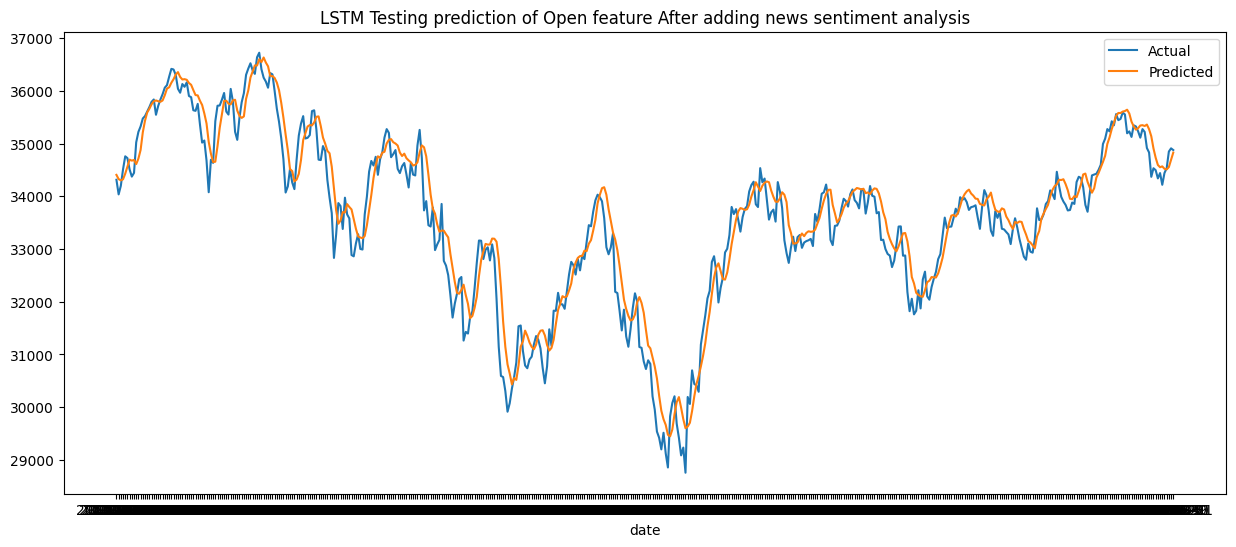

Mean square error for Open =190261.68082569644
Total mean square error 190261.68082569644


In [37]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_news)